# Simulation of RCT EMS v3

Three scenarios: 

1. weekday
2. weekend
3. weekend with disaster

Three dispatch policies for ambulance selection: 
1. fastest ambulance 
2. least coverage disruption
3. optimal by weighting travel time and coverage

Nine total simulations, each compared. 

# Case count distributions

Each simulation has 100 cases regardless of how the scenarios will play out. This should mean that the disaster scenario will finish 100 cases in less time because there is a disaster time slot where many cases occur. We want to see if this is the case by comparing the disaster scenarios against the weekday and weekend scenarios. The dispatch policy might affect the distributions, but probably not be too much. 

# Cases reached before r1: 10 minutes

Since previous RCT studies looked at using the US EMS Act as the standard, we want to know how many cases are reached before the 10 minute requirement. If this is not reached, it's still helpful to know if the case was reached before the 14 minute secondary coverage requirement. 

Since Pons stated 8 minutes is the time when statistics actually found significant difference in case effectiveness, it may be useful to count the cases reached before 8 minutes. 

# Double coverage 

Plot the double coverage of the simulated RCTs over time. Here, the dispatch policy is important, and the specific scenarios may or may not make a difference. We expect to see best travel to do the worst, but weighted should have similar shape with best travel time despite being a little better. 

<hr/>

In [202]:
# Use matplotlib to graph and not bokeh (learn curve). 
# No command line magic, only analysis. 

# %matplotlib notebook
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.max_open_warning': 0})

plt.rcParams['figure.figsize'] = 8, 8

import pandas
import scipy.stats as stats
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from numpy import median, mean


from datetime import datetime, timedelta

from functools import reduce
from collections import Counter
import yaml 

<hr/>

#       READ DATA INTO THE NOTEBOOK:

In [203]:
csvs = [ # Every simulation produces these files.
    "chosen_ambulances.csv",
    "chosen_bases.csv",
    "chosen_hospitals.csv",
    "metrics.csv",
    "processed_cases.csv",
]

scenarios = [ # Three scenarios, two from the RCT, one additional contributed scenario 
    "weekday",
    "weekend",
    "disaster", # Note that the base scenario is weekend with a disaster intejected inside
]

policies = [ # Three ambulance dispatch policies were tested 
    "best-travel",
    "best-coverage",
    "weighted-dispatch",
]

result_directories = [ # This notebook is assumed to be in the home project repository directory. 
    "tj-{scenario}-{policy}/".format(scenario=scenario, policy=policy) \
    for scenario in scenarios for policy in policies
]

data_files = [
    directory + csv \
    for directory in result_directories for csv in csvs
]

# Test the filenames and counts formed correctly

# for r in result_directories: print(r) 
# print(len(result_directories))

# for f in data_files: print(f) 
# print(len(data_files))


def read_folder(data_files):
    
    """
    For each folder (simulation), read in their csv results
    
    data_files: a list of strs pointing to each csv file in the results
    returns: a dict(k: scenario, policy, data_name, v: pandas representation of the csv)
    """
    
    assert isinstance(data_files, list) 
    for data in data_files: assert isinstance(data, str)
    return {data: pandas.read_csv("./results/" + data) for data in data_files}


dataset = read_folder(data_files) # Now the source of truth for data

# Test the data set 
# for k in dataset.keys(): print(k); print(type(dataset[k]))
# print(len(dataset))

# EMERGENCY CASE DISTRIBUTIONS DRAWN OVER THE ZONES

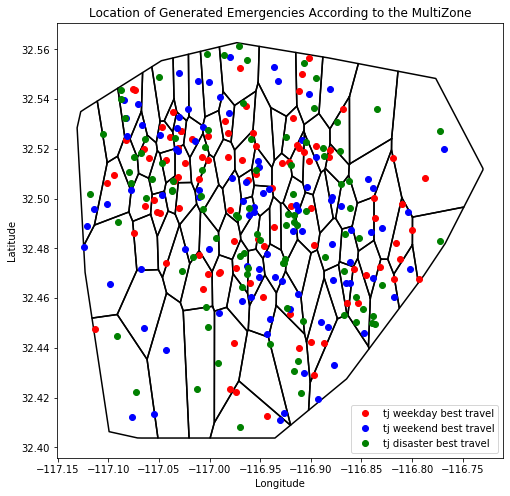

Take out the slicing from line 26 if want *every* case plotted.


In [204]:
title = "Location of Generated Emergencies According to the MultiZone"
plt.figure(title)
plt.title(title)
plt.xlabel("Longitude")
plt.ylabel("Latitude")


# Read the polygons and draw the matplotlibs. Return lat longs, as longs lats (xs ys)
xs = yaml.full_load(open('../longitudes.yaml'))
ys = yaml.full_load(open('../latitudes.yaml'))



for i in range(len(xs)):
    plt.plot(xs[i] + [xs[i][0]], ys[i] + [ys[i][0]],  '-', color='black')


# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}

gen_cases = {filename: cases[filename] for filename in cases if "best-travel" in filename}

colors = ['green', 'blue', 'red']

for case_name in gen_cases:
    label = case_name.split('/')[0].replace('-', ' ')
    plt.plot(cases[case_name].longitude[0:500], cases[case_name].latitude[0:500], 'o', 
             color=colors.pop(), label=label)

plt.legend()
plt.show()

print("Take out the slicing from line 26 if want *every* case plotted.")

In [205]:
# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}

gen_cases = {filename: cases[filename] for filename in cases if "best-travel" in filename}

for name in gen_cases:
    continue # UNCOMMENT TO DISPLAY SEPARATE GRAPHS
    plt.figure(name)
    plt.title(name)
    for i in range(len(xs)):
        plt.plot(xs[i] + [xs[i][0]], ys[i] + [ys[i][0]], )
    plt.plot(gen_cases[name].longitude, gen_cases[name].latitude, '.', color='black')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# CASE COUNT DISTRIBUTIONS

In [226]:
# Define the functions necessary to accumulate each set of case datetimes 
# in order to bin them into histographic distributions.

# Draw the histogram for each scenario, before drawing a histogram for all scenarios

# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}


    
def plot_histogram_basic(processed_cases, name):
    """
    For each list of processed cases, draw the histogram distribution of cases per hour.
    """
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic towards the histogram 
    dates = [datetime.strptime(arr[1], '%Y-%m-%d %H:%M:%S.%f').replace(
        minute=0, second=0, microsecond=0) for arr in processed_cases.values]
    
    first = dates[0]
    deltas = [(date-first).total_seconds()/3600 for date in dates]
    
    c = Counter(deltas)
    sum(c.values())

    l = list(deltas)

    # Logic towards the smooth histogram
    smooth_xs = np.linspace(int(min(c.keys())), int(max(c.keys())), len(c.keys()))
    spl = make_interp_spline(list(c.keys()), list(c.values()), k=3)
    smooth_ys = spl(smooth_xs)
    
    
    # Draw the blocky histogram
    figure_title = "Case count per hour: " + name + ""
    plt.figure(figure_title)
    plt.title(figure_title)
    ys, xs, patches = plt.hist(deltas, bins=int((max(deltas)+1)/1), histtype='step')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')

    # Draw the smoothed histogram
    plt.hist(deltas, bins=int((max(deltas)+1)), histtype='step', color='black')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    # plt.ylim(0,10)
    plt.plot(smooth_xs, smooth_ys, '-', color='red')
    
    plt.show()
    


# Draw each processed cases' case count. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
#     plot_histogram_basic(processed_cases, name) 
    pass
    
    
    
def histogram_collapsed(processed_cases, name):
    """
    For each list of processed cases, draw the histogram distribution of cases per hour.
    """
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
#     print(name)
    
    # Logic towards the histogram 
    dates = [datetime.strptime(arr[1], '%Y-%m-%d %H:%M:%S.%f').replace(
        minute=0, second=0, microsecond=0) for arr in processed_cases.values]
    
    first = dates[0]
    deltas = [(date-first).total_seconds()/3600 for date in dates]
    
    c = Counter(deltas)
    sum(c.values())

    l = list(deltas)

    # Logic towards the smooth histogram
    smooth_xs = np.linspace(int(min(c.keys())), int(max(c.keys())), len(c.keys()))
    spl = make_interp_spline(list(c.keys()), list(c.values()), k=3)
    smooth_ys = spl(smooth_xs)
    
    
    # Draw the blocky histogram
    figure_title = "Cases per hour, all"
#     plt.figure(figure_title)
#     plt.title(figure_title)
#     ys, xs, patches = plt.hist(deltas, bins=int((max(deltas)+1)/1), histtype='step')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    plt.xlim(0,24)

    # Draw the smoothed histogram
    plt.hist(deltas, bins=int((max(deltas)+1)), histtype='step', color='grey')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    plt.ylim(0,32)
    label = name.split('/')[0].replace('-', ' ')
#     print(label)
    plt.plot(smooth_xs, smooth_ys, '-', label=label)




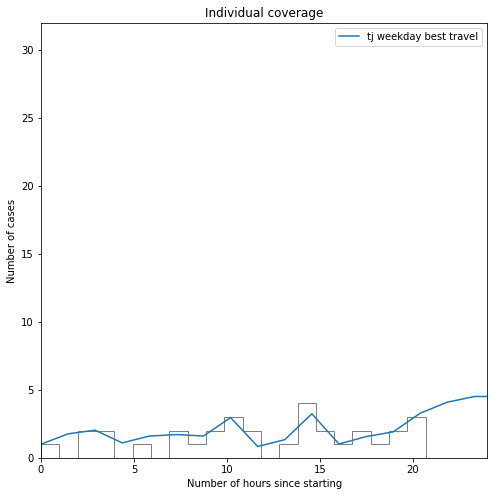

In [227]:
individual_coverage = "Individual coverage"
plt.figure(individual_coverage)
plt.title(individual_coverage)
for name, processed_cases in cases.items():
    if "weekday-best-travel" in name:
#         print(name)
        histogram_collapsed(processed_cases, name) 
plt.legend()    
plt.show()

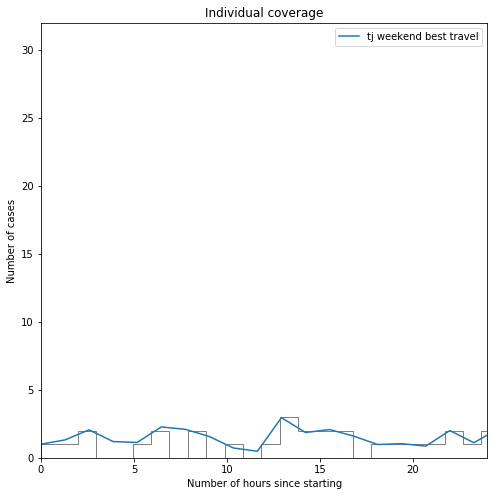

In [228]:
plt.figure(individual_coverage)
plt.title(individual_coverage)
for name, processed_cases in cases.items():
    if "weekend-best-travel" in name:
#         print(name)
        histogram_collapsed(processed_cases, name) 
plt.legend()
plt.show()

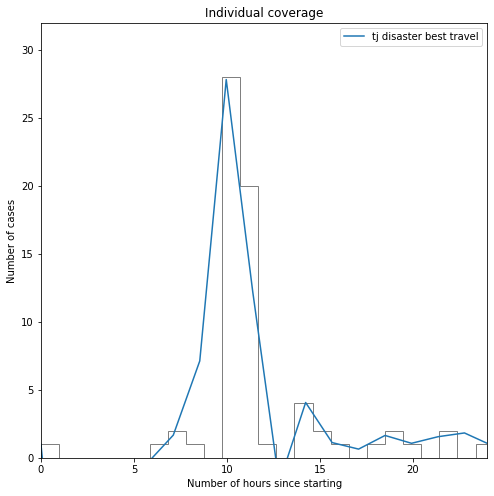

In [229]:
plt.figure(individual_coverage)
plt.title(individual_coverage)
for name, processed_cases in cases.items():
    if "disaster-best-travel" in name:
#         print(name)
        histogram_collapsed(processed_cases, name) 
plt.legend()
plt.show()

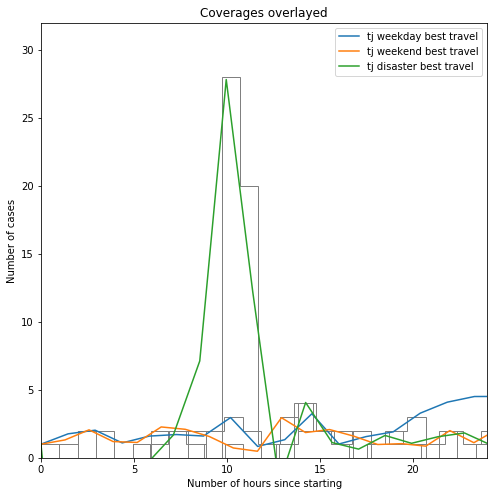

In [230]:
all_coverages='Coverages overlayed'
plt.figure(all_coverages)
plt.title(all_coverages)
for name, processed_cases in cases.items():
    if "best-travel" in name:
        histogram_collapsed(processed_cases, name) 
        
plt.legend()
plt.show()

Comments:
1. Seems like the case distribution for each hour are the same. 
2. This is pretty expected, since the density of cases is not extremely high, we don't hit the case delay scenario too often (really, only in the disaster scenario). 
3. Because of that, the major differences here are between each scenario, which makes sense. 

# REACHING EMERGENCY POINTS WITHIN TIME LIMIT

<Figure size 576x576 with 0 Axes>

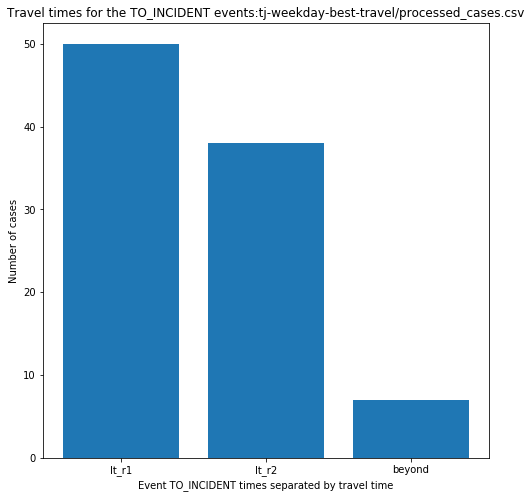

{'lt_r1': 50, 'lt_r2': 38, 'beyond': 7}
****************************************



<Figure size 576x576 with 0 Axes>

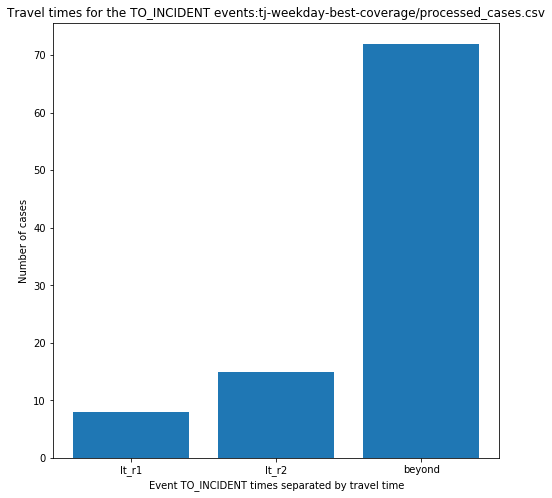

{'lt_r1': 8, 'lt_r2': 15, 'beyond': 72}
****************************************



<Figure size 576x576 with 0 Axes>

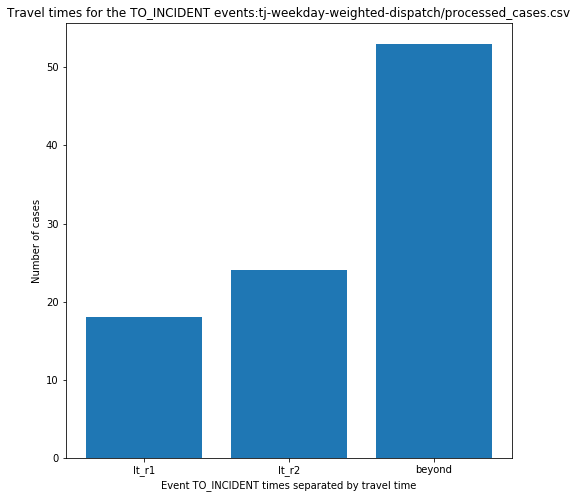

{'lt_r1': 18, 'lt_r2': 24, 'beyond': 53}
****************************************



<Figure size 576x576 with 0 Axes>

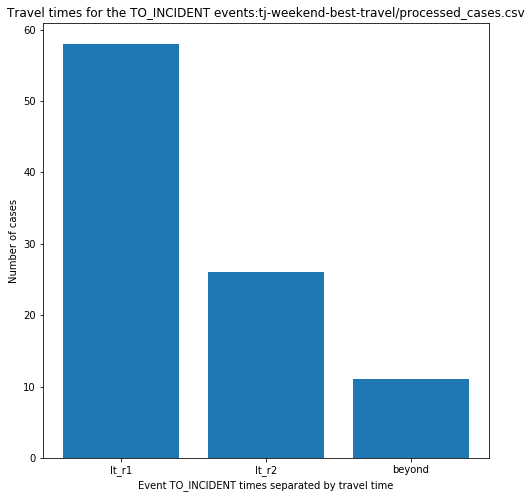

{'lt_r1': 58, 'lt_r2': 26, 'beyond': 11}
****************************************



<Figure size 576x576 with 0 Axes>

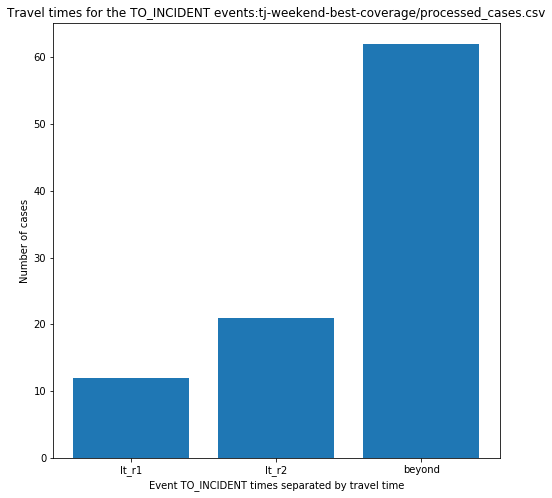

{'lt_r1': 12, 'lt_r2': 21, 'beyond': 62}
****************************************



<Figure size 576x576 with 0 Axes>

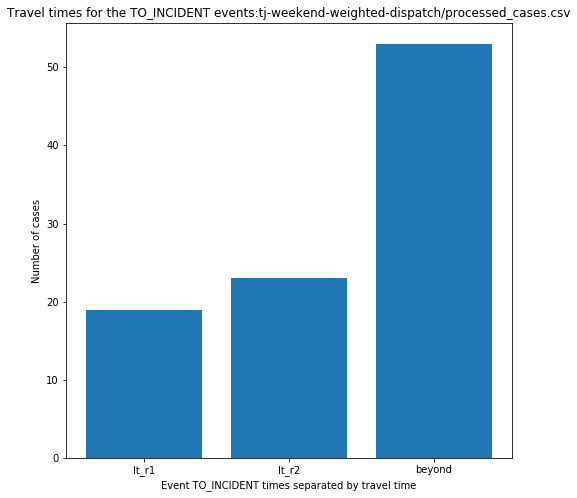

{'lt_r1': 19, 'lt_r2': 23, 'beyond': 53}
****************************************



<Figure size 576x576 with 0 Axes>

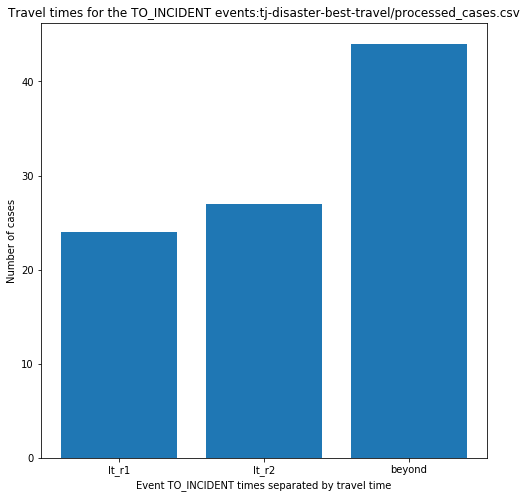

{'lt_r1': 24, 'lt_r2': 27, 'beyond': 44}
****************************************



<Figure size 576x576 with 0 Axes>

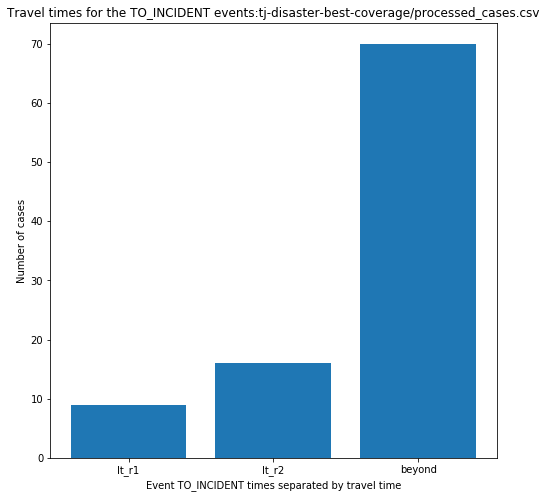

{'lt_r1': 9, 'lt_r2': 16, 'beyond': 70}
****************************************



<Figure size 576x576 with 0 Axes>

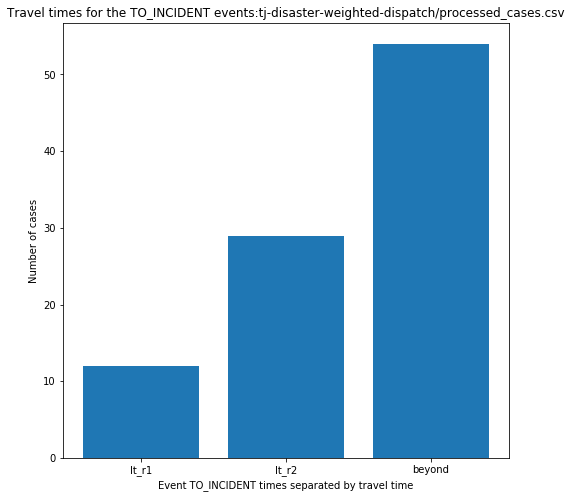

{'lt_r1': 12, 'lt_r2': 29, 'beyond': 54}
****************************************



In [211]:
# to incident durations

def plot_travel_times_basic(processed_cases, name):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    
    # Draw the bar graphs

    figure_title = "Travel times for the TO_INCIDENT events:" + name
    plt.figure(figure_title)
    plt.title(figure_title)

    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Event TO_INCIDENT times separated by travel time")
    plt.ylabel('Number of cases')
    
    plt.show()
    print(counts)
    print('*'*40 + '\n')
    
#     return

# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
#     continue # DON'T NEED UNSEPARATED PRIORITIES
    plt.figure()
    plot_travel_times_basic(processed_cases, name) 


Comments
1. This one is actually really interesting. 
2. Least disruption is terrible in all scenarios and this makes sense because this dispatch policy goes against the whole point of EMS which is to **quickly** reach the patient.
3. In the Weekdays scenario, there was no change between BTT and weighted.
4. In the Weekends scenario, BTT did the best. However, we do not know whether it was **necessary** for this to happen. 
5. In the disaster scenario, weighted did the best. It seems like a few of the r2's became r1, and some other r2's went beyond r2. 
6. None of this paints a complete picture, because we're not only interested in how many cases were filled in r1, but we're also interested in, of these cases, how many **top priority** cases were reached with r1. 

Note: different scenarios produced a different set of cases so at the moment it's mainly just worth comparing within scenarios 

# Event.TO_INCIDENT for Priority 1 only

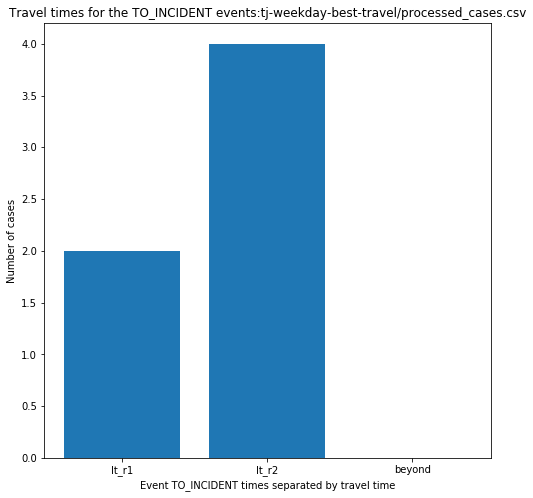

{'lt_r1': 2, 'lt_r2': 4, 'beyond': 0}
****************************************



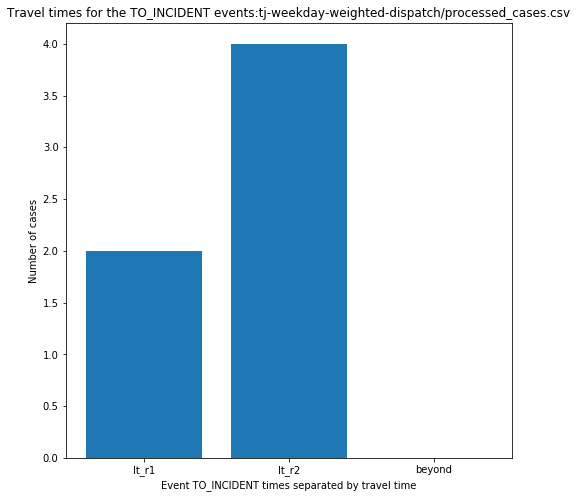

{'lt_r1': 2, 'lt_r2': 4, 'beyond': 0}
****************************************



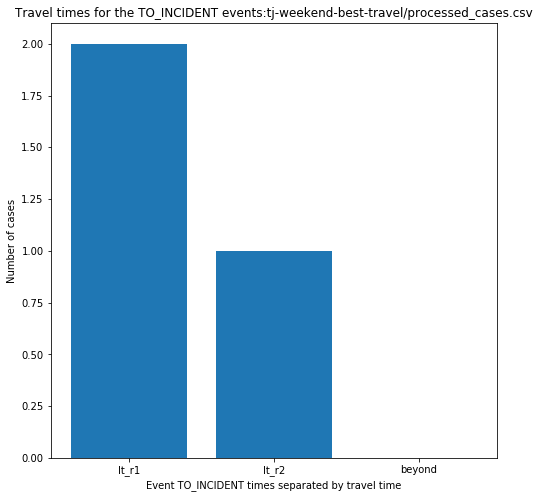

{'lt_r1': 2, 'lt_r2': 1, 'beyond': 0}
****************************************



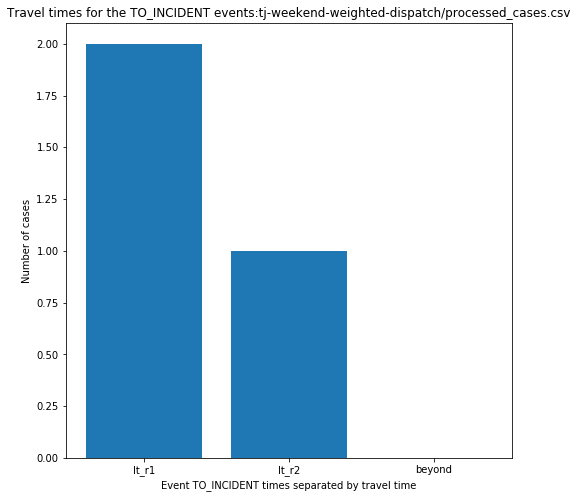

{'lt_r1': 2, 'lt_r2': 1, 'beyond': 0}
****************************************



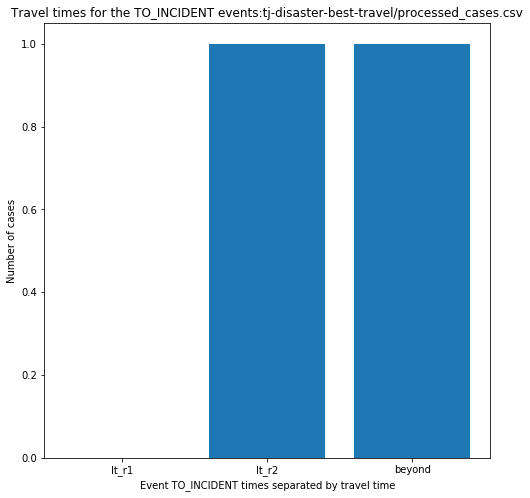

{'lt_r1': 0, 'lt_r2': 1, 'beyond': 1}
****************************************



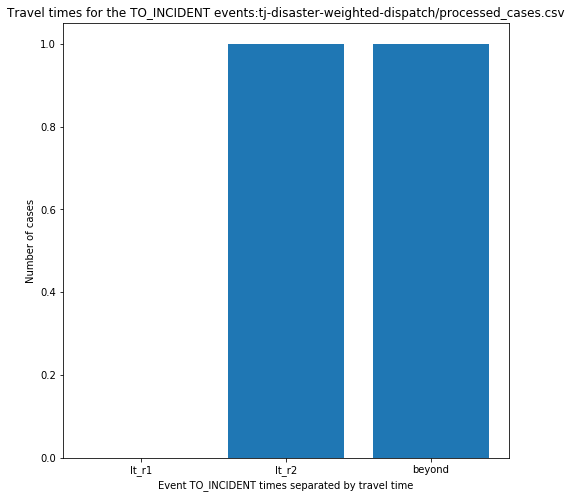

{'lt_r1': 0, 'lt_r2': 1, 'beyond': 1}
****************************************



In [212]:
# Implement the exact same code as above, but filter for the Priority 1 cases. 

def plot_travel_times_priority1(processed_cases, name):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values 
                 if array[4] == 1]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    
    # Draw the bar graphs

    figure_title = "Travel times for the TO_INCIDENT events:" + name
    plt.figure(figure_title)
    plt.title(figure_title)

    plt.bar(counts.keys(), counts.values())
    plt.xlabel("Event TO_INCIDENT times separated by travel time")
    plt.ylabel('Number of cases')
    
    plt.show()
    print(counts)
    print('*'*40 + '\n')
    
#     return

# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
    if "best-coverage" in name: 
        continue
    plot_travel_times_priority1(processed_cases, name) 

# AVERAGE TRAVEL TIME FOR EACH PRIORITY

In [213]:
def average_travel_times_priority(processed_cases, name, priority):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values 
                 if array[4] == priority]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    avg = mean(durations).total_seconds()
    total = sum([t.total_seconds() for t in durations])
    
    print(name, priority)
    print(counts)
    print("Average to_incident duration: ", avg)
    print("Total time in seconds for E1: ", total)


# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for priority in range(1, 5):
    for name, processed_cases in cases.items():
        if "coverage" in name: 
            continue
        average_travel_times_priority(processed_cases, name, priority) 
        print()
    print("#"*80)

tj-weekday-best-travel/processed_cases.csv 1
{'lt_r1': 2, 'lt_r2': 4, 'beyond': 0}
Average to_incident duration:  585.166666666
Total time in seconds for E1:  3511.0

tj-weekday-weighted-dispatch/processed_cases.csv 1
{'lt_r1': 2, 'lt_r2': 4, 'beyond': 0}
Average to_incident duration:  585.166666666
Total time in seconds for E1:  3511.0

tj-weekend-best-travel/processed_cases.csv 1
{'lt_r1': 2, 'lt_r2': 1, 'beyond': 0}
Average to_incident duration:  600.666666666
Total time in seconds for E1:  1802.0

tj-weekend-weighted-dispatch/processed_cases.csv 1
{'lt_r1': 2, 'lt_r2': 1, 'beyond': 0}
Average to_incident duration:  504.666666666
Total time in seconds for E1:  1514.0

tj-disaster-best-travel/processed_cases.csv 1
{'lt_r1': 0, 'lt_r2': 1, 'beyond': 1}
Average to_incident duration:  934.0
Total time in seconds for E1:  1868.0

tj-disaster-weighted-dispatch/processed_cases.csv 1
{'lt_r1': 0, 'lt_r2': 1, 'beyond': 1}
Average to_incident duration:  934.0
Total time in seconds for E1:  18

Finally, after using the new formula for weighing the two dispatches, a lot of the priority 4 cases have been sacrificed to improve priorities 1-3. There are definite improvements in Priority 2 and 3 cases, while the Priority 1 cases remained the same. It was hoped that priority 1 would improve as well and maybe that will happen after double coverage is implemented.

# COVERAGE FOR EACH SIMULATION

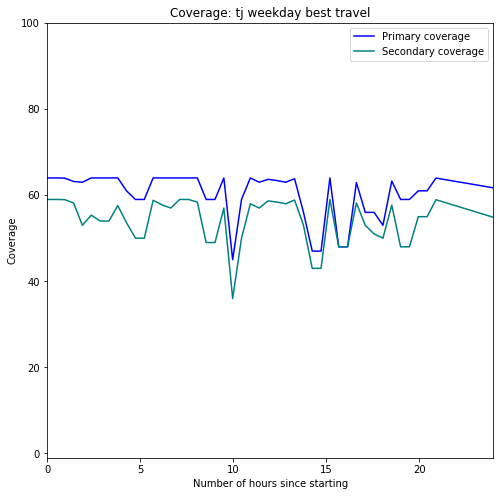

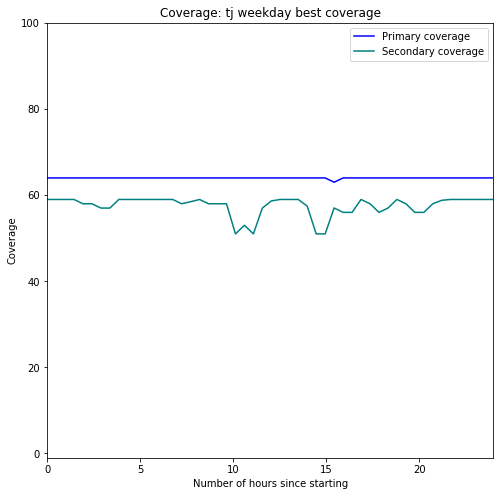

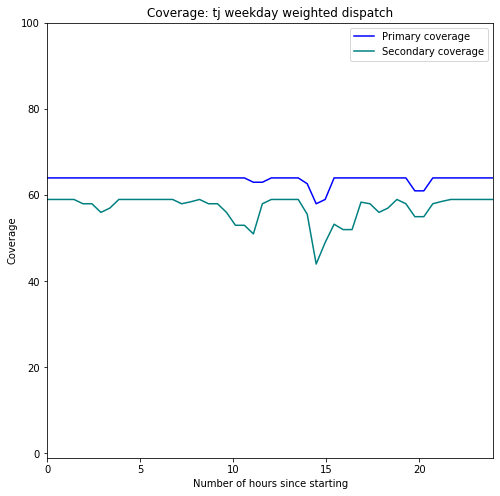

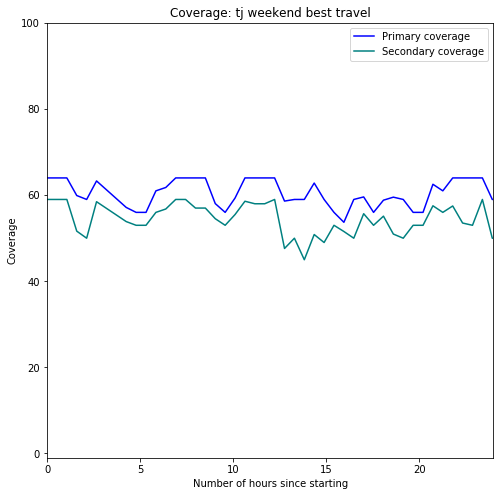

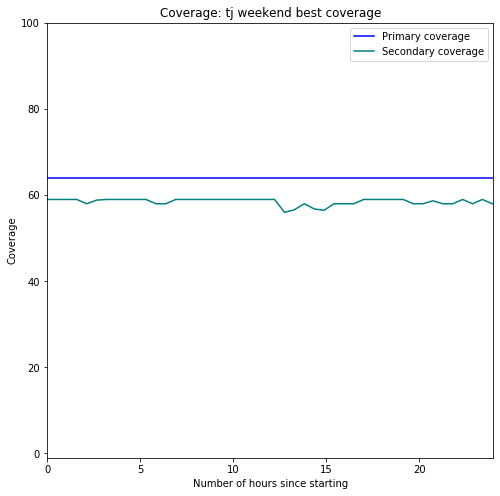

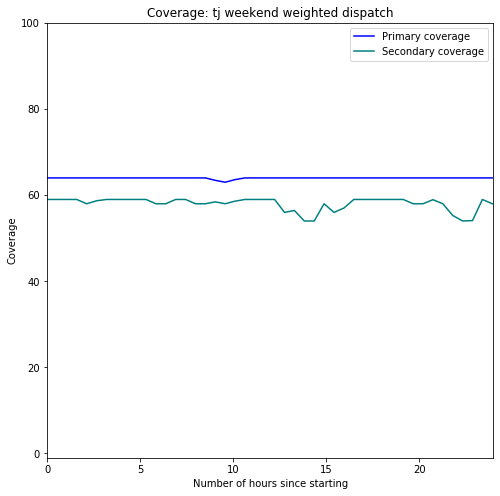

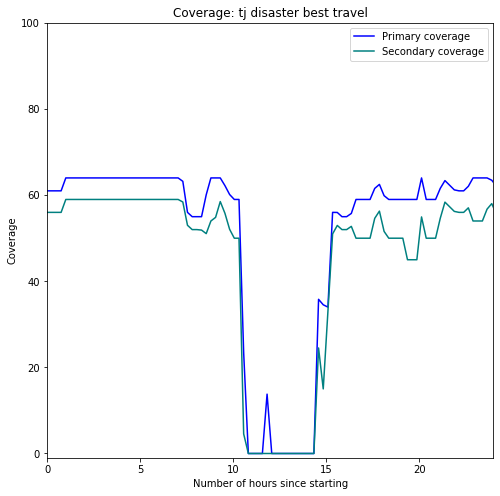

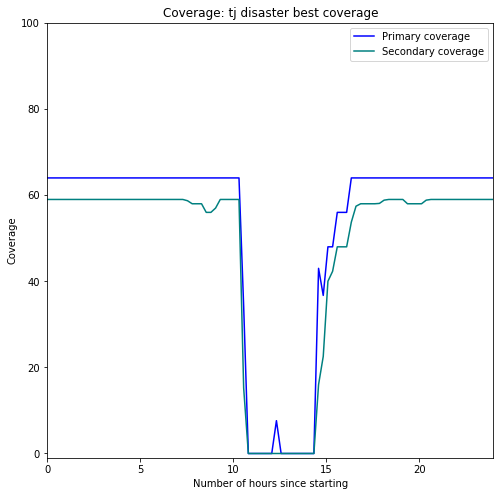

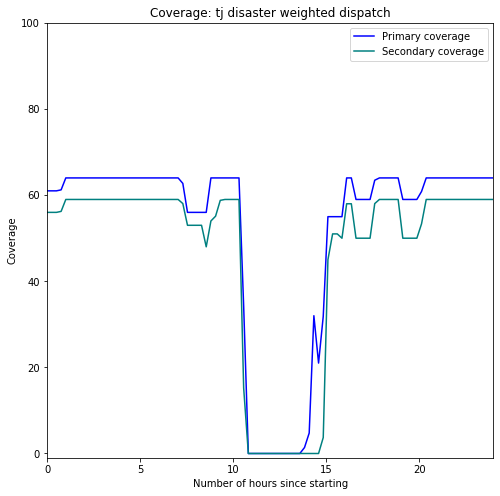

In [231]:
metrics = {k:v for k,v in dataset.items() if "metrics" in k}

def draw_coverage_basic(metrics, name):

    coverages = [(pandas.to_datetime(arr[0]), float(arr[1]), float(arr[2])) for arr in metrics.values]
    coverages.sort()

    xs = [cov[0] for cov in coverages]
    ys = [cov[1] for cov in coverages]
    ys2 = [cov[2] for cov in coverages]

    first = xs[0]
    xs = [(date-first).total_seconds()/3600 for date in xs]

    # Smoothed the original
    smooth_xs = np.linspace(int(min(xs)), int(max(xs)), len(xs)//4)

    spl = make_interp_spline(xs, ys, k=1)
    smooth_ys = spl(smooth_xs)
    
    spl2 = make_interp_spline(xs, ys2, k=1)
    smooth_ys2 = spl2(smooth_xs)

    name = name.split('/')[0].replace('-', ' ')
    figure_title = "Coverage: " + name
    plt.figure(figure_title)
    plt.title(figure_title)
    plt.xlim(0,24)
    plt.ylim(-1, 100)
    plt.xlabel("Number of hours since starting"); plt.ylabel('Coverage')

    plt.plot(smooth_xs, smooth_ys, '-', color='blue', label='Primary coverage')
    plt.plot(smooth_xs, smooth_ys2, '-', color='teal', label='Secondary coverage')
    
    plt.legend()
    plt.show()
    

for name, metric in metrics.items(): 
    draw_coverage_basic(metric, name)
    pass

Comments: 
1. Just based on the primary coverage (double is currently missing), it seems like the BTT finished all the cases the soonest. However, as we saw above with the travel times, it's interesting because less cases were reached within r1 using btt. Again, with the travel times, it's going to be interesting to see whether more high priority cases were reached (or maybe **all of the disaster cases** are high/top priority? Probably requires more thought...) And also the double coverage is going to paint a better picture of what's happening. 

In [215]:
def draw_coverage_overlayed(metrics, name, colors):

    coverages = [(pandas.to_datetime(arr[0]), float(arr[1]), float(arr[2])) for arr in metrics.values]
    coverages.sort()

    xs = [cov[0] for cov in coverages]
    ys = [cov[1] for cov in coverages]
    ys2 = [cov[2] for cov in coverages]

    first = xs[0]
    xs = [(date-first).total_seconds()/3600 for date in xs]

#     print(all([xs[i] <= xs[i+1] for i in range(len(xs)-1)]))

    # Smoothed the original
    smooth_xs = np.linspace(int(min(xs)), int(max(xs)), len(xs)//4)

    spl = make_interp_spline(xs, ys, k=1)
    smooth_ys = spl(smooth_xs)
    
    spl2 = make_interp_spline(xs, ys2, k=1)
    smooth_ys2 = spl2(smooth_xs)


    figure_title = "Coverage: overlayed"
    plt.figure(figure_title)
    plt.title(figure_title)
    plt.ylim(-1, 100)
    plt.xlim(0, 24 )
    plt.xlabel("Number of hours since starting")
    plt.ylabel('Coverage')

#     plt.plot(xs, ys, 'b.' )

    plt.plot(smooth_xs, smooth_ys, '-', color=colors.pop(), label=name + "-primary")
    plt.plot(smooth_xs, smooth_ys2, '-', color=colors.pop(), label=name + "-secondary")
    plt.legend()


In [216]:
def plot_overlay(term):
    plt.figure()
    colors = ['blue', 'teal', 'red', 'orange', 'black', 'grey']
    for name, metric in metrics.items(): 
        if term in name: 
            plot_colors = [colors.pop(), colors.pop()]
            print(name, plot_colors)
            draw_coverage_overlayed(metric, name, plot_colors)
    print("Note: the colors are [secondary color, primary color].")
    plt.show()

tj-weekday-best-travel/metrics.csv ['grey', 'black']
tj-weekday-best-coverage/metrics.csv ['orange', 'red']
tj-weekday-weighted-dispatch/metrics.csv ['teal', 'blue']
Note: the colors are [secondary color, primary color].


<Figure size 576x576 with 0 Axes>

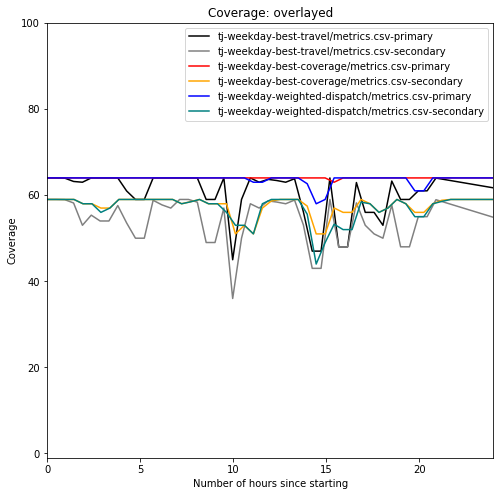

In [217]:
plot_overlay("weekday")

tj-weekend-best-travel/metrics.csv ['grey', 'black']
tj-weekend-best-coverage/metrics.csv ['orange', 'red']
tj-weekend-weighted-dispatch/metrics.csv ['teal', 'blue']
Note: the colors are [secondary color, primary color].


<Figure size 576x576 with 0 Axes>

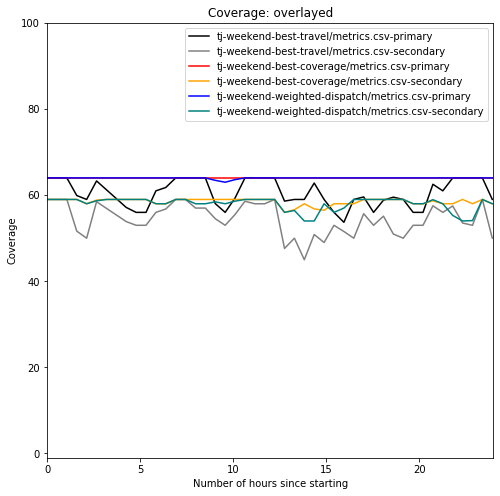

In [218]:
plot_overlay("weekend")

tj-disaster-best-travel/metrics.csv ['grey', 'black']
tj-disaster-best-coverage/metrics.csv ['orange', 'red']
tj-disaster-weighted-dispatch/metrics.csv ['teal', 'blue']
Note: the colors are [secondary color, primary color].


<Figure size 576x576 with 0 Axes>

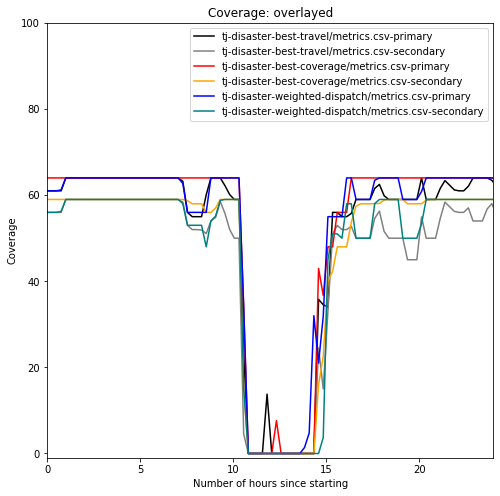

In [219]:
plot_overlay("disaster")

tj-weekday-best-travel/metrics.csv ['grey', 'black']
tj-weekend-best-travel/metrics.csv ['orange', 'red']
tj-disaster-best-travel/metrics.csv ['teal', 'blue']
Note: the colors are [secondary color, primary color].


<Figure size 576x576 with 0 Axes>

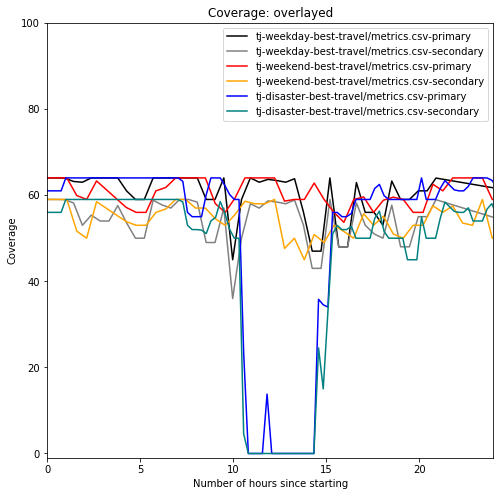

In [220]:
plot_overlay("best-travel")

tj-weekday-best-coverage/metrics.csv ['grey', 'black']
tj-weekend-best-coverage/metrics.csv ['orange', 'red']
tj-disaster-best-coverage/metrics.csv ['teal', 'blue']
Note: the colors are [secondary color, primary color].


<Figure size 576x576 with 0 Axes>

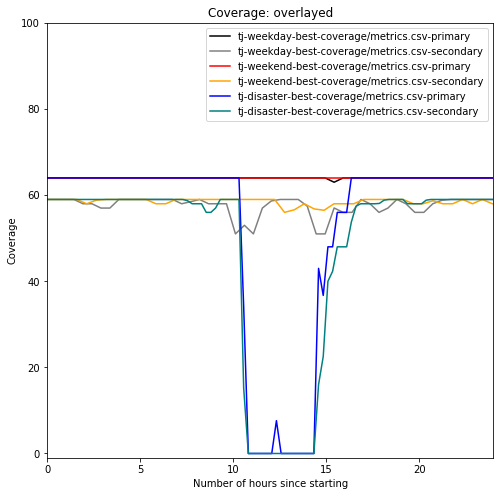

In [221]:
plot_overlay("coverage")

tj-weekday-weighted-dispatch/metrics.csv ['grey', 'black']
tj-weekend-weighted-dispatch/metrics.csv ['orange', 'red']
tj-disaster-weighted-dispatch/metrics.csv ['teal', 'blue']
Note: the colors are [secondary color, primary color].


<Figure size 576x576 with 0 Axes>

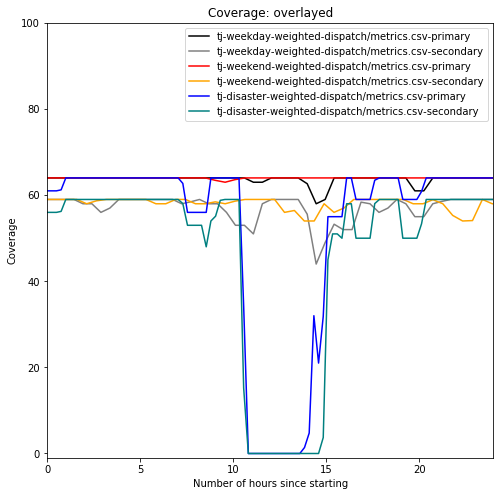

In [222]:
plot_overlay("weighted-dispatch")